In [1]:
import fastai
from fastai.vision import *
import shutil
import os
import cv2
FOLD=3
work_dir = Path('/kaggle/working/')
path = Path('../input/')

source=path/'leaderboard_test_data'
destination= Path('../input/psuedo_images/')

train = path/'train_images/train_images'
test =  path/'leaderboard_test_data/leaderboard_test_data'
holdout = path/'leaderboard_holdout_data/leaderboard_holdout_data'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'
test_labels = '../input/sub-test/test_label.csv'

df_sample = pd.read_csv(sample_sub)

In [2]:
!pip install pretrainedmodels

    100% |████████████████████████████████| 61kB 2.5MB/s 
  Running setup.py bdist_wheel for pretrainedmodels ... - done
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from sklearn.metrics import roc_auc_score
def auc_score(preds,targets):
    return torch.tensor(roc_auc_score(targets,preds[:,1])*100)

In [4]:
df = pd.read_csv(labels)
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [5]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [6]:
import pretrainedmodels
def model_f(pretrained=True,**kwargs):
    return pretrainedmodels.se_resnext101_32x4d(num_classes=1000,pretrained='imagenet')

In [7]:
folds = StratifiedKFold(n_splits=11, random_state=2019)

y = df['has_oilpalm'].values

for fold_, (trn_, val_) in enumerate(folds.split(df, y)):
    if fold_==FOLD:
      train_x, trn_y = df.loc[trn_], y[trn_]
      val_x, val_y   = df.loc[val_], y[val_]
      filename = "resnext101_32x4d_tfms_" + str(fold_)
      filename_sub = filename+"_sub.csv"

      print("fold : ", fold_, train_x.shape,val_x.shape,trn_y.mean(),val_y.mean())

      src = (ImageItemList.from_df(df, path, folder=train)
          .split_by_idxs(train_x.index, val_x.index)
          .label_from_df('has_oilpalm')
          .add_test(test_names+holdout_names))

      data =  (src.transform(get_transforms(), size=256)
             .databunch(bs=16)#50
             .normalize(imagenet_stats))
    
      #learn = create_cnn(data=data,arch= model_f,cut=-2, metrics=[accuracy], model_dir='/kaggle/working/models')
        


fold :  3 (13858, 3) (1386, 3) 0.061769375090200605 0.06204906204906205


In [8]:
def getLearner():
    return create_cnn(data=data,arch= model_f,cut=-2, pretrained=True,  metrics=accuracy, ps=0.5, callback_fns=ShowGraph, model_dir='/kaggle/working/models')
learner = getLearner()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /tmp/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth
100%|██████████| 196466866/196466866 [00:08<00:00, 24171251.50it/s]


In [9]:
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


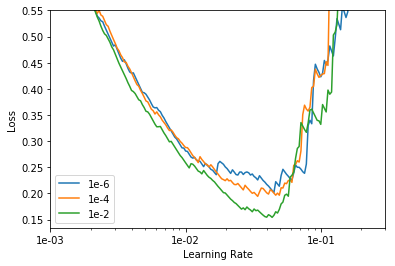

In [10]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [11]:
max_lr = 1e-3
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, lr=1e-2, wd=wd)

TypeError: fit_one_cycle() got an unexpected keyword argument 'lr'

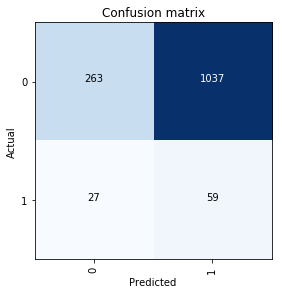

In [12]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')


In [13]:
learner.save('_stage1')

In [14]:
# load the baseline model
#learner.load( '_stage1')
# unfreeze and run learning rate finder again
learner.unfreeze()
#learner.lr_find(wd=wd)
# plot learning rate finder results
#learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.357624,0.218505,0.967532
2,0.081556,0.042531,0.988456
3,0.059486,0.034413,0.989899
4,0.050849,0.032080,0.990620


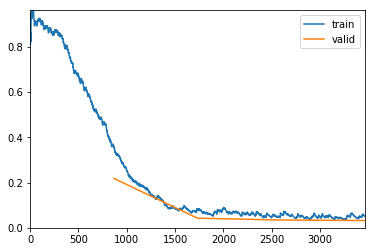

In [15]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=4, max_lr=slice(1e-6,1e-4))

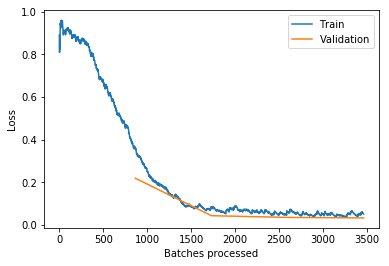

In [16]:
learner.recorder.plot_losses()

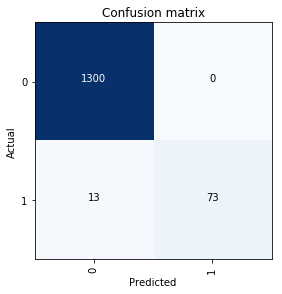

In [17]:
# lets take a second look at the confusion matrix. See if how much we improved.
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [18]:
# Save the finetuned model
learner.save( '_stage2')


In [19]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.990620493888855 %.


In [20]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Positive']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,6, figsize=(24,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(6):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(6):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(6):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

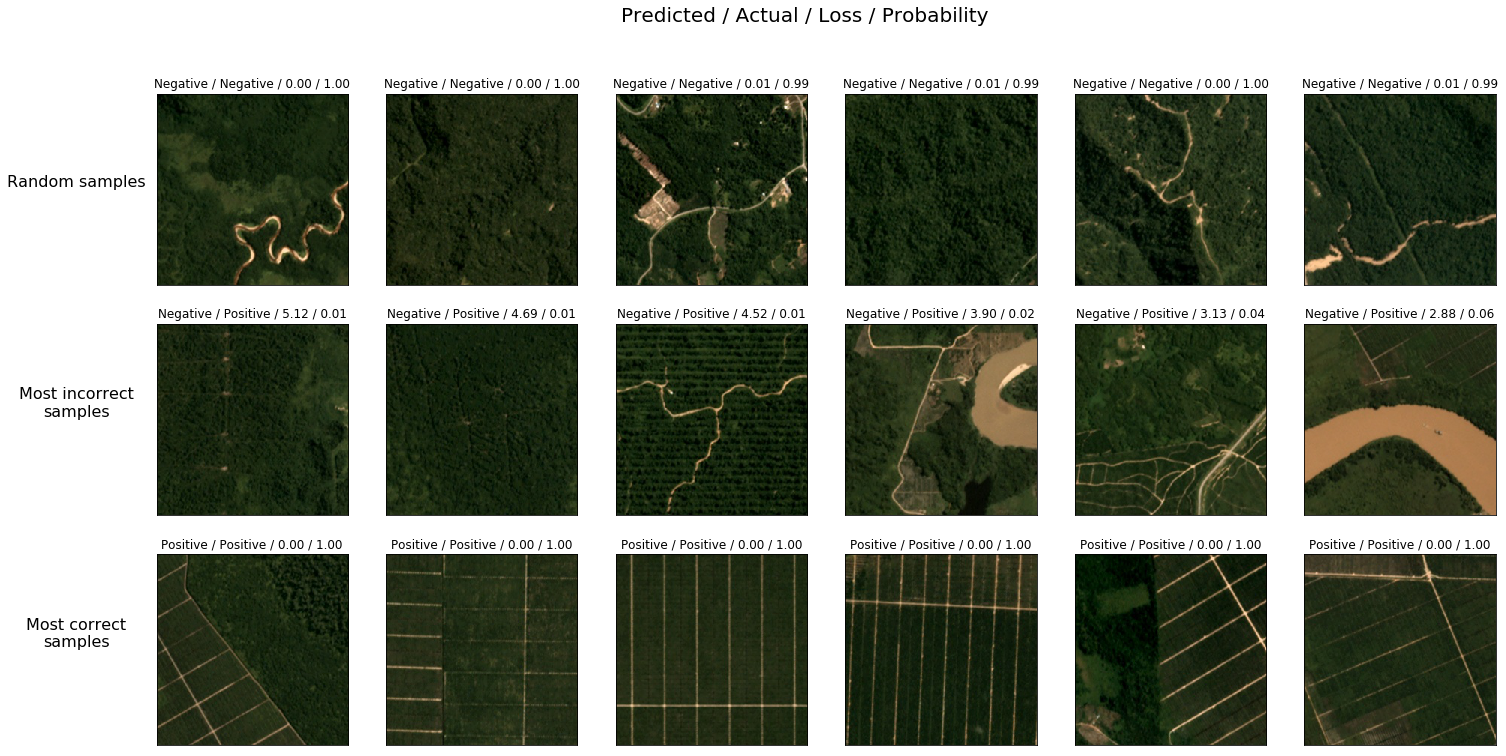

In [21]:
plot_overview(interp, ['Negative','Positive'])


Gradient-weighted Class Activation Mapping (Grad-CAM)

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

This method produces a coarse localization map highlighting the areas that the model considers important for the classification decision. The visual explanation gives transparency to the model making it easier to notice if it has learned the wrong things. For example, if we would train a dog breed classifier and all of our images of a certain dog breed would have been taken in a dog show competition. There is a good chance that the model would learn to recognize the competition surroundings instead of doggy features with that breed. Visualizing the localization map would reveal that, and we could focus on getting more diverse data of that breed.


In [22]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [23]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = data.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = data.one_item(tensorImg)
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [24]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Positive']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,6, figsize=(24,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(6):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(6):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(6):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

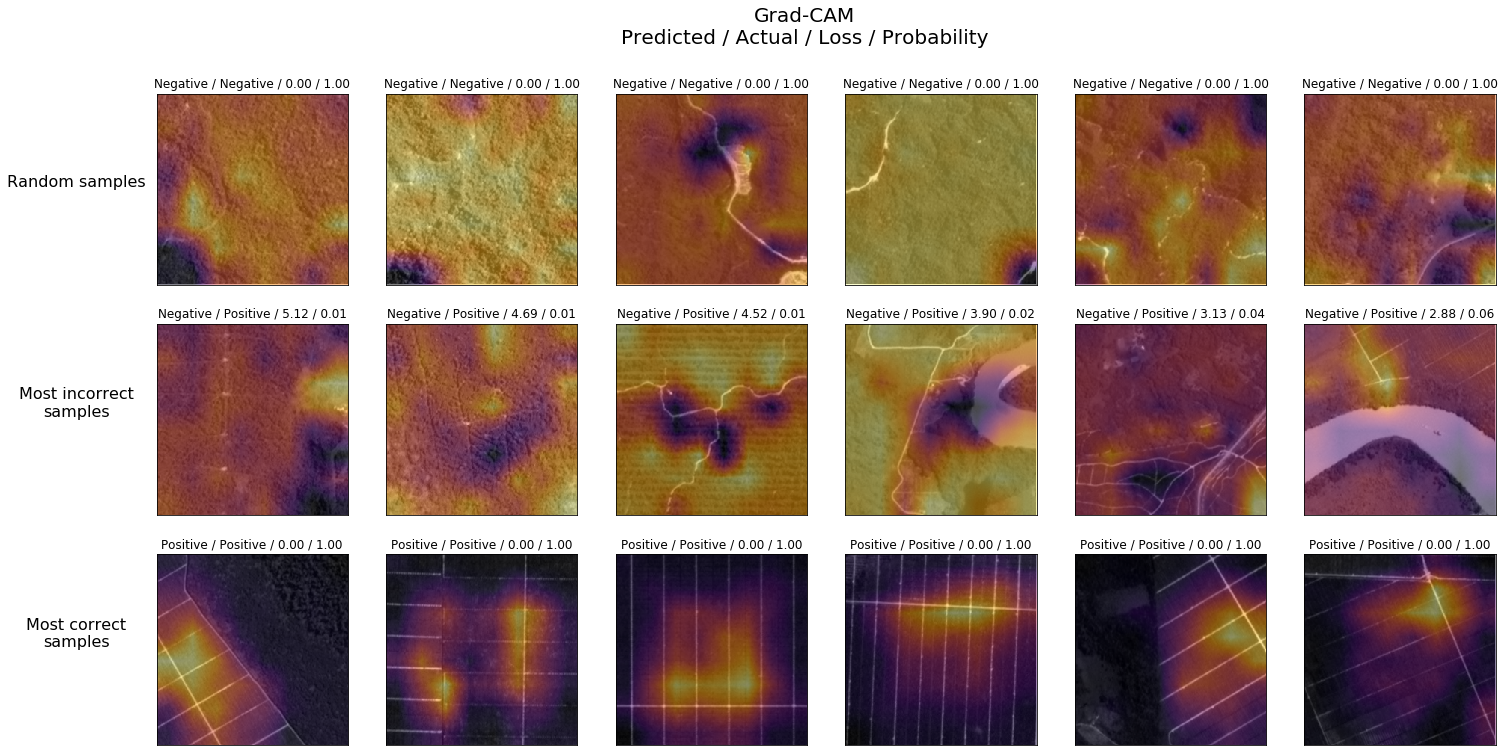

In [25]:
plot_heatmap_overview(interp, ['Negative','Positive'])

In [26]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9939355992844364


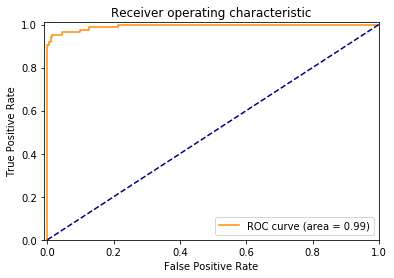

In [27]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [28]:
if 1:
      sub = pd.DataFrame()
      p,t = learner.TTA(ds_type=DatasetType.Test)
      p = to_np(p); p.shape
      ids = np.array([f.name for f in (test_names+holdout_names)]);ids.shape
      sub_tmp = pd.DataFrame(np.stack([ids, p[:,1]], axis=1), columns=df_sample.columns)
      sub=pd.concat([sub,sub_tmp],axis=0) 
      
      sub.to_csv('submission.csv', index=False)